# Redes Neuronales
## Preparacion de datos para el modelo

In [1]:
#Primero separamos el dataset en train y test.
#Para eso debemos ordenar segun fecha, elegimos columna 'Opportunity_Created_Date'
#Por conveniencia codifico ahora a la columna Stage como 1 o 0 si es 'Closed Won' o 'Closed Lost'

import Utilidades as ut
import numpy as np
import pandas as pd


df_train = pd.read_pickle("Neuronales_train.pkl")
df_test = pd.read_pickle("Neuronales_validation.pkl")

x_train, y_train = ut.split_labels(df_train)
x_test, y_test = ut.split_labels(df_test)


#Convertimos las fechas a numeros (cantidad de dias transcurridos) y luego las normalizamos
x_train, x_test = ut.conversion_fechas(x_train, x_test)
x_train, x_test = ut.codificar_categoricas(x_train, y_train, x_test)
x_train, x_test = ut.normalizacion_numericas(x_train, x_test, modo='normalizacion')

x_train.head(3)

,Region,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Billing_Country,Account_Owner,Opportunity_Owner,...,Total_Product_Family_Region_Month_Change,Total_Products_Region_This_Week,Total_Products_Region_Last_Week,Total_Products_Region_Week_Change,Total_Products_Region_This_Month,Total_Products_Region_Last_Month,Total_Products_Region_Month_Change,Total_Products_Region_This_Quarter,Total_Products_Region_Last_Quarter,Total_Products_Region_Quarter_Change
0,-3.61,-2.05,-1.14,-0.89,-0.64,-2.08,-1.34,-2.5,-2.11,-1.85,...,-1.2,-1.24,-1.25,-1.3,-2.00,-2.01,-7.05,-2.27,-2.28,-17.51
1,-3.61,0.49,0.88,1.12,1.56,-2.08,-0.95,-2.5,-2.11,-1.85,...,-1.2,-1.24,-1.25,-1.3,-2.00,-2.01,-7.05,-2.27,-2.28,-17.51
2,-3.61,0.49,-1.14,1.12,-0.64,-2.08,-1.28,-2.5,-2.11,-1.85,...,-1.2,-1.21,-1.25,-1.3,-1.99,-2.01,-7.05,-2.27,-2.28,-17.51


## Creacion del modelo.

In [2]:
import keras
import tensorflow as tf
from keras import backend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2


x_train_vector = ut.df_a_vector(x_train)
y_train_vector = ut.df_a_vector(y_train)
x_test_vector = ut.df_a_vector(x_test)
y_test_vector = ut.df_a_vector(y_test)

input_dim = x_train.shape[1]

alfa = 1e-3

model = Sequential()
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(256, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(128, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='tanh'))
model.add(Dropout(0.25))
model.add(Dense(16, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
model.add(Dense(8, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

backend.set_value(model.optimizer.learning_rate, 5e-4)

epochs = 500
batch_size = 256


my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Neuronales_Mejor_Modelo.hdf5", 
                                       monitor='val_accuracy', 
                                       verbose=1,
                                       save_best_only=True, 
                                       mode='max'),
    
    tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                     min_delta=0.01,
                                     mode='max',
                                     patience=10),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                      mode='max',
                                      factor=0.8,
                                      patience=5,
                                      cooldown=0, 
                                      min_lr=1e-8)
]

history = model.fit(x_train_vector, 
                    y_train_vector, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(x_test_vector, y_test_vector),
                    callbacks=my_callbacks)

Epoch 1/500
44/47 [===========================>..] - ETA: 0s - loss: 5.7409 - accuracy: 0.4802
Epoch 00001: val_accuracy improved from -inf to 0.60593, saving model to Neuronales_Mejor_Modelo.hdf5
47/47 [==============================] - 1s 27ms/step - loss: 5.6269 - accuracy: 0.4848 - val_loss: 3.5519 - val_accuracy: 0.6059 - lr: 5.0000e-04
Epoch 2/500
46/47 [============================>.] - ETA: 0s - loss: 3.5790 - accuracy: 0.5482
Epoch 00002: val_accuracy improved from 0.60593 to 0.61796, saving model to Neuronales_Mejor_Modelo.hdf5
47/47 [==============================] - 1s 19ms/step - loss: 3.5784 - accuracy: 0.5478 - val_loss: 3.3945 - val_accuracy: 0.6180 - lr: 5.0000e-04
Epoch 3/500
43/47 [==========================>...] - ETA: 0s - loss: 3.4705 - accuracy: 0.5683
Epoch 00003: val_accuracy improved from 0.61796 to 0.65248, saving model to Neuronales_Mejor_Modelo.hdf5
47/47 [==============================] - 1s 16ms/step - loss: 3.4654 - accuracy: 0.5697 - val_loss: 3.2898 - 

In [4]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_test).flatten()

df_entrega = pd.DataFrame({'Opportunity_ID' : range(1000, 1000+len(y_pred))})

df_entrega['Target'] = pd.Series(y_pred)
df_entrega['Target'] = df_entrega.groupby('Opportunity_ID').transform('mean')
df_entrega['Target'] = (df_entrega['Target'] > 0.5).astype(int)
df_entrega

#df_entrega.to_csv('Prueba_Entrega.csv', index=False)

,Opportunity_ID,Target
0,1000,0
1,1001,0
2,1002,0
3,1003,0
4,1004,0
...,...,...
4484,5484,0
4485,5485,0
4486,5486,0
4487,5487,0


In [5]:
#keras.backend.clear_session()

In [6]:
#model.save('Neuronales_7740.h5')

## Resultados

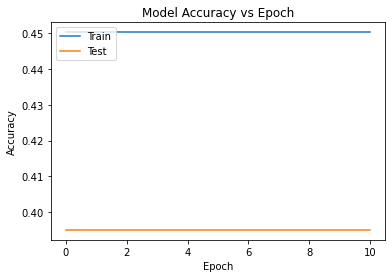

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
new_model = keras.models.load_model('Neuronales_Mejor_Modelo.hdf5')
#new_predictions = new_model.predict(x_test)

In [9]:
from sklearn.metrics import accuracy_score

#y_pred = np.argmax(model.predict(x_test_vector), axis=-1)

#acc_test = accuracy_score(y_pred, y_test_vector)
#print(f'Accuracy del test: {acc_test*100}%')

from sklearn.metrics import accuracy_score

score = new_model.evaluate(x_test_vector, y_test_vector, batch_size=256)
score

ValueError: in user code:

    /home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:941 test_function  *
        outputs = self.distribute_strategy.run(
    /home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:909 test_step  **
        y_pred = self(x, training=False)
    /home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_22 is incompatible with the layer: expected axis -1 of input shape to have value 43 but received input with shape [None, 59]


In [ ]:
#N = 100

for _ in range(N):
    #Entrenar
    
    #Guardar pesos